In [ ]:
!pip install tfds-nightly
!git clone https://github.com/huggingface/transformers.git
!pip install -e /content/transformers/
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/lxmert.zip
!unzip lxmert.zip
!pip install wget

fatal: destination path 'transformers' already exists and is not an empty directory.
Obtaining file:///content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Found existing installation: transformers 4.6.0.dev0
    Can't uninstall 'transformers'. No files were found to uninstall.
  Running setup.py develop for transformers
--2021-05-10 12:47:52--  https://aiffelstaticprd.blob.core.windows.net/media/documents/lxmert.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33029 (32K) [application/zip]
Saving to: ‘lxmert.zip.1’

lxmert.zip.1        100%[===================>]  32.25K   136KB/s    in 0.2s    

2021-05-10 12:47:54 (136 KB/s) - ‘lxmert.zip.1’ saved [33029/3

In [ ]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.


from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
# sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
sys.path.append('/content')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

1.8.1+cu101


In [ ]:
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"

lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [ ]:
gqa_answers = utils.get_data(GQA_URL)
print(len(gqa_answers))
print(gqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

1842
['cat food', 'elephant', 'gloves', 'football', 'dock', 'shops', 'water', 'light blue', 'chair', 'players', 'tourist', 'magnet', 'railroad', 'ski lift', 'mirror', 'leggings', 'hurdle', 'shuttle', 'wildflowers', 'flowers', 'cooking pot', 'pipe', 'swan', 'girl', 'celery', 'brown', 'ambulance', 'steps', 'power line', 'asphalt']


In [ ]:
# 위 이미지의 URL
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000125397.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [ ]:
test_questions_for_url1 = [
    "Where is this scene?",
    "What is it on the picture?",
    "What is on the summit",
    "What is the color of the train?"
]
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin /root/.cache/torch/transformers/tmpoyoqqvbp



loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
tensor([[[3.2790e+02, 2.4461e+02, 4.1530e+02, 3.1192e+02],
         [2.6101e+02, 2.1680e+02, 3.2518e+02, 2.7298e+02],
         [4.4836e+02, 3.0194e+00, 6.3772e+02, 2.1934e+02],
         [3.4777e+02, 1.0601e+02, 3.9584e+02, 1.3085e+02],
         [5.1152e+02, 3.8195e+02, 5.6979e+02, 4.2700e+02],
         [2.4488e+02, 1.3973e+02, 3.2611e+02, 2.3120e+02],
         [1.5237e+02, 2.0496e+02, 

In [ ]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


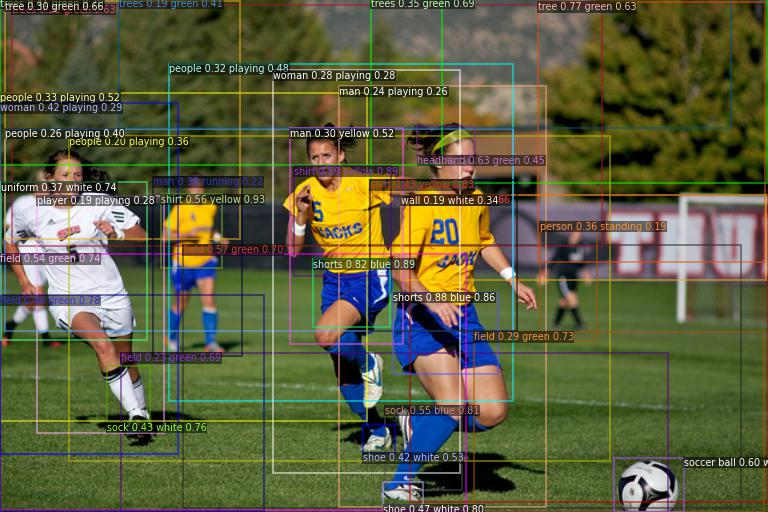

In [ ]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [ ]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")


In [ ]:
test_questions_for_url1 = [
    "Where is this scene?",
    "What are they playing?",
    "What kind of sports are they doing",
    "What is the color of the ball?"
]

for test_question in test_questions_for_url1:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['Where is this scene?']
prediction from LXMERT VQA: field
Question: ['What are they playing?']
prediction from LXMERT VQA: soccer
Question: ['What kind of sports are they doing']
prediction from LXMERT VQA: soccer
Question: ['What is the color of the ball?']
prediction from LXMERT VQA: white
